# 15-1. 프로젝트: 더 멋진 번역기 만들기
### 라이브러리

In [109]:
import tensorflow
import numpy as np
import matplotlib
import os
import re
import sentencepiece as spm
import matplotlib.pyplot as plt


print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

2.6.0
1.21.4
3.4.3


### Step 1. 데이터 다운로드 (클라우드 유저용)


In [6]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

### Step 2. 데이터 정제 및 토큰화


In [7]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # 중복 데이터 제거
    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [9]:
# 정제 함수 정의
def preprocess_sentence(sentence):
    
    # 소문자 변환
    sentence = sentence.lower()
    
    # 알파벳, 문장부호, 한글 제외한 문자 제거
    sentence = re.sub(r"[^a-zA-Z0-9ㄱ-ㅣ가-힣!.?]+", " ", sentence)
    
    # 문장부호 양옆에 공백 추가
    sentence = re.sub(r"([?.!])", r" \1 ", sentence)
    
    # 문장 앞 뒤 불필요한 공백 제거
    sentence = sentence.strip()
    
    return sentence

In [10]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # [[YOUR CODE]]
    # 문장 데이터를 파일로 저장
    with open(f"{lang}_corpus.txt", "w") as f:
        for sentence in corpus:
            f.write(sentence + "\n")
    
    model_prefix = f"{lang}_tokenizer"
    
    # Train SentencePiece tokenizer
    spm.SentencePieceTrainer.train(
        f"--input={lang}_corpus.txt --model_prefix={model_prefix} --vocab_size={vocab_size}" + 
        f" --pad_id={pad_id} --pad_piece=[PAD]" +
        f" --unk_id={unk_id} --unk_piece=[UNK]" +
        f" --bos_id={bos_id} --bos_piece=[BOS]" +
        f" --eos_id={eos_id} --eos_piece=[EOS]" +
        " --model_type=unigram --max_sentence_length=999999")

    # Load tokenizer
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{model_prefix}.model")
    
    return tokenizer


In [14]:

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=ko_corpus.txt --model_prefix=ko_tokenizer --vocab_size=20000 --pad_id=0 --pad_piece=[PAD] --unk_id=3 --unk_piece=[UNK] --bos_id=1 --bos_piece=[BOS] --eos_id=2 --eos_piece=[EOS] --model_type=unigram --max_sentence_length=999999
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extreme

True

In [15]:
# 토큰화된 문장 출력해보기
kor_sentence = "이것은 테스트 문장입니다."
en_sentence = "This is a test sentence."

print("Korean:", ko_tokenizer.encode_as_pieces(kor_sentence))
print("English:", en_tokenizer.encode_as_pieces(en_sentence))

Korean: ['▁이것', '은', '▁테스트', '▁문', '장', '입니다', '.']
English: ['[BOS]', '▁', 'T', 'hi', 's', '▁is', '▁a', '▁test', '▁sentence', '.', '[EOS]']


In [16]:
# 토큰 길이 50 이하인 데이터만으로 src_corpus, tgt_corpus 구축 하고 enc_train, dec_train으로 변환
from tqdm.notebook import tqdm
import tensorflow as tf

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    if len(ko_tokenizer.encode_as_ids(kor_corpus[idx])) <= 50 and len(en_tokenizer.encode_as_ids(eng_corpus[idx])) <= 50:
        src_corpus.append(kor_corpus[idx])
        tgt_corpus.append(eng_corpus[idx])

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(
    [ko_tokenizer.encode_as_ids(sentence) for sentence in src_corpus],
    padding='post'
)
dec_train = tf.keras.preprocessing.sequence.pad_sequences(
    [en_tokenizer.encode_as_ids(sentence) for sentence in tgt_corpus],
    padding='post'
)


  0%|          | 0/78968 [00:00<?, ?it/s]

In [61]:
print("src corpus:", len(src_corpus))
print("tgt corpus:", len(tgt_corpus))

src corpus: 72885
tgt corpus: 72885


## Step 3. 모델 설계

### 1. 2 layer 갖는 transformer 선언


In [35]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [83]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)
        
        # Scaled QK 값 구하기

        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        #1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        
        #2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)
        
        return out, attentions


    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0,2,1,3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0,2,1,3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        out = self.combine_heads(out)
        out = self.linear(out)
        return out, attention_weights



In [84]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out


In [85]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn



In [86]:
# DecoderLayer 클래스를 작성하세요.
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [87]:
# 인코더, 디코더 클래스 정의
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns



In [88]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns



In [89]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        # embedding layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        # positional encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        # encoder, decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        # output linear
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        #shared weight
        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        # dropout
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
         
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [90]:
# masking
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask



In [91]:
transformer = Transformer(n_layers=2, d_model=256, n_heads=8, d_ff=2048,
                          src_vocab_size=32000,  # 한국어 어휘 크기
                          tgt_vocab_size=32000,  # 영어 어휘 크기
                          pos_len=50) # 모델의 최대 입력 길이


### 2. learning rate scheduler, adam optimizer 선언

In [92]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)


### 3. loss 함수 정의

In [93]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 4. train_step 함수 정의

In [94]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns


### 5. 학습 진행
이때 매 epoch마다 제시된 예문에 대한 번역 생성하기

In [95]:

# 학습
import random
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_33/640958841.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the dow jones was a smaller .
Input: 커피는 필요 없다.
Predicted translation: but we re not because .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two people were killed in the city of the city of the city of the city of the city of the city of the city of the city of the city of the city of the city of the city of the two .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president elect obama s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the storm is a long .
Input: 커피는 필요 없다.
Predicted translation: it s not a lot of the heart .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed in the deaths .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the storm is the water .
Input: 커피는 필요 없다.
Predicted translation: coffee and it s not to be a lot of coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were dead .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s main square .
Input: 커피는 필요 없다.
Predicted translation: the coffee is nobody s .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a city of water .
Input: 커피는 필요 없다.
Predicted translation: coffee such as you need to be able to stop .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were killed .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obamas .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of myanmar is a city of water .
Input: 커피는 필요 없다.
Predicted translation: coffee shops need to be a fair .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were dead .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect to be in the obama election .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a city of a city .
Input: 커피는 필요 없다.
Predicted translation: coffee shops are required .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were dead .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a better job .
Input: 시민들은 도시 속에 산다.
Predicted translation: there are a city in the city .
Input: 커피는 필요 없다.
Predicted translation: it needs to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the dead .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it is a president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: it is a city of water .
Input: 커피는 필요 없다.
Predicted translation: it needs to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in seven deaths .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect in the office of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: there s a city that s a city is in the city .
Input: 커피는 필요 없다.
Predicted translation: it s very fairy tale .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in seven death .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a typical election .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is almost a city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in seven death .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it is obama from illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is also filled .
Input: 커피는 필요 없다.
Predicted translation: drilling needs to be coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in seven death .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a day .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city was started at a city .
Input: 커피는 필요 없다.
Predicted translation: it needs necessary to sit down at coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died wednesday afternoon in clashes between the dead .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it is obama the president elect to president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are expected to go on .
Input: 커피는 필요 없다.
Predicted translation: the coffee didn t need for any introduced .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in casualties in the seven death .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it will be mccain .
Input: 시민들은 도시 속에 산다.
Predicted translation: there are once city in there .
Input: 커피는 필요 없다.
Predicted translation: its need to be coffee he said of the fairy tale
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in another fire .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the typical republican candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: local citizens are seen in cities .
Input: 커피는 필요 없다.
Predicted translation: van der need any larger .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the dead .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s the president elect to president .
Input: 시민들은 도시 속에 산다.
Predicted translation: it is almost a city .
Input: 커피는 필요 없다.
Predicted translation: van like vansu
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died wednesday in another fire .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s that obama s 15 day .
Input: 시민들은 도시 속에 산다.
Predicted translation: town it is almost easily to go home .
Input: 커피는 필요 없다.
Predicted translation: vans are demanding larger
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died across seven of the deadly left seven people dead .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a red .
Input: 시민들은 도시 속에 산다.
Predicted translation: once city is stuck in there .
Input: 커피는 필요 없다.
Predicted translation: van wished no .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in greatest fire .


  0%|          | 0/1139 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s coming obama s old .
Input: 시민들은 도시 속에 산다.
Predicted translation: once half the city is stuck in at cool .
Input: 커피는 필요 없다.
Predicted translation: sits straight away at the larger islands
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died wednesday in seven so far .


### 6. 번역 생성

In [69]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [55]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [56]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [101]:
example_sentence = "나는 길을 잃어버려서 다른 사람에게 도움을 요청했다."
translate(example_sentence, transformer, ko_tokenizer, en_tokenizer)

Input: 나는 길을 잃어버려서 다른 사람에게 도움을 요청했다.
Predicted translation: i lost everything i asked for help and asking him for help .


In [107]:
pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(example_sentence, transformer, ko_tokenizer, en_tokenizer)


In [112]:
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')  # 리눅스의 경우 나눔고딕 폰트를 사용하도록 변경해주세요.

# 그래프에서 마이너스 기호가 표시되도록 설정
plt.rc('axes', unicode_minus=False)


Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


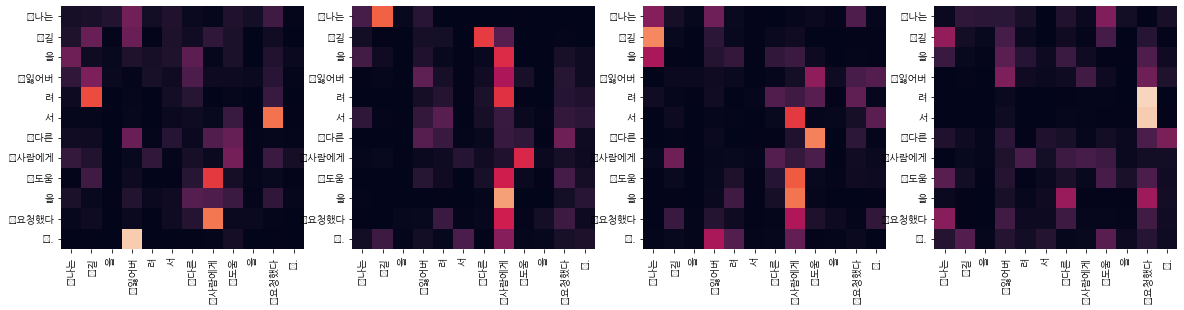

Encoder Layer 2


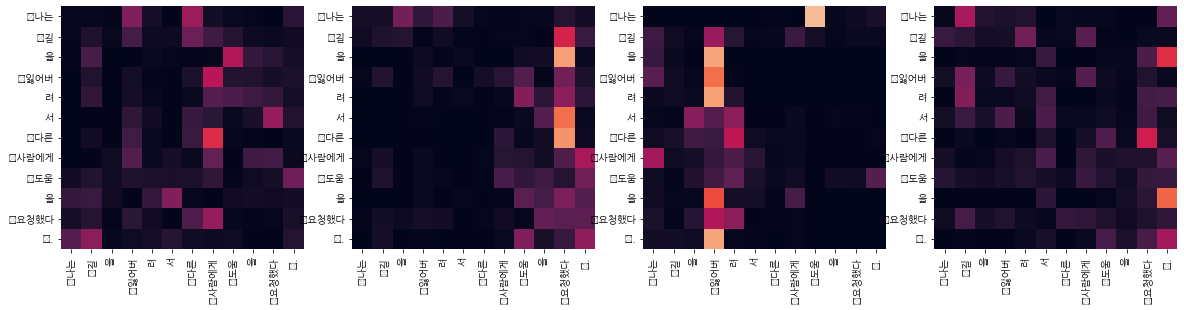

Decoder Self Layer 1


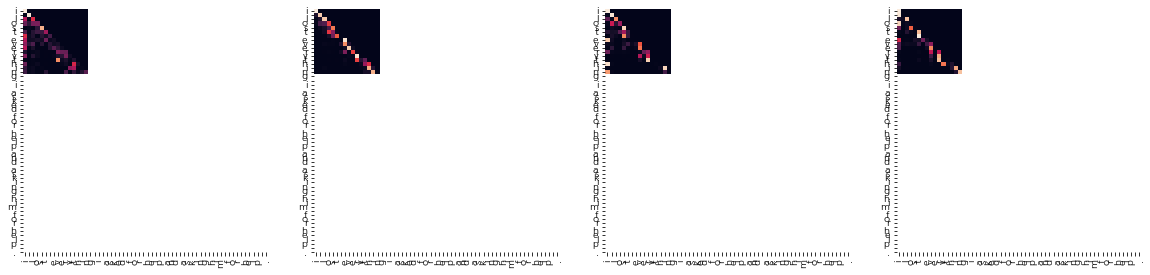

Decoder Src Layer 1


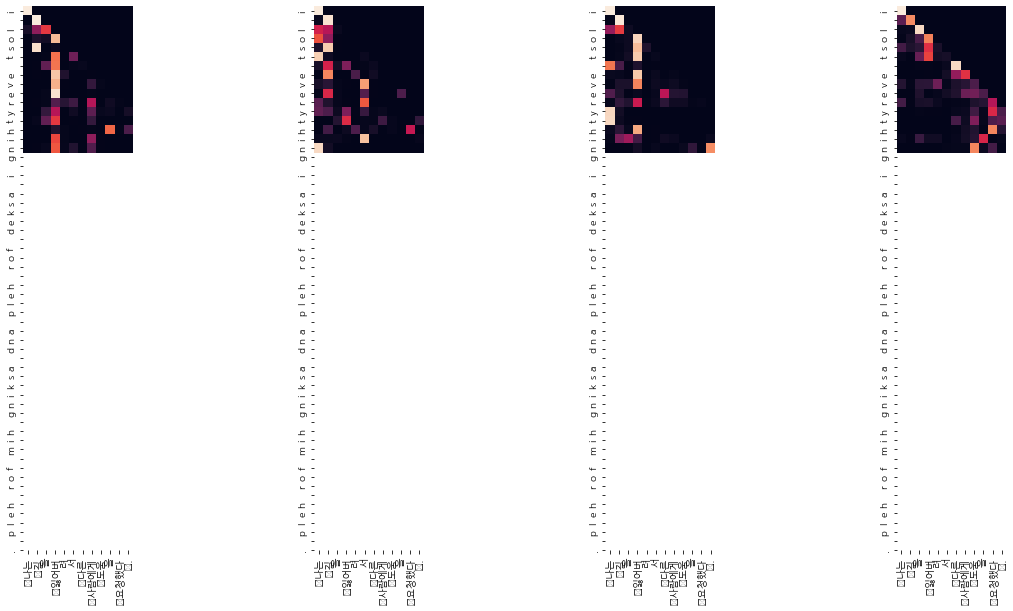

Decoder Self Layer 2


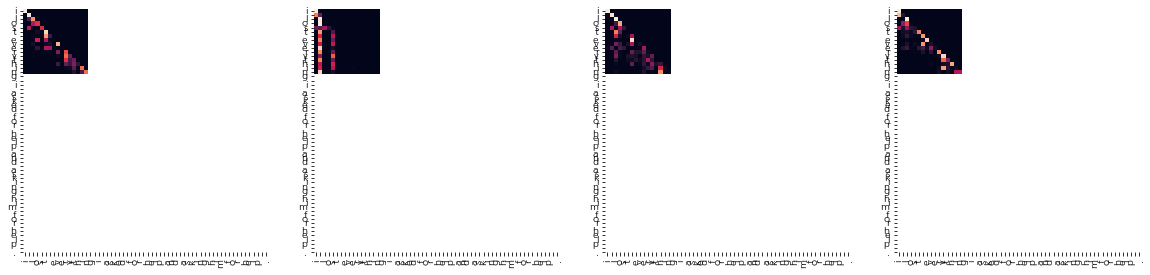

Decoder Src Layer 2


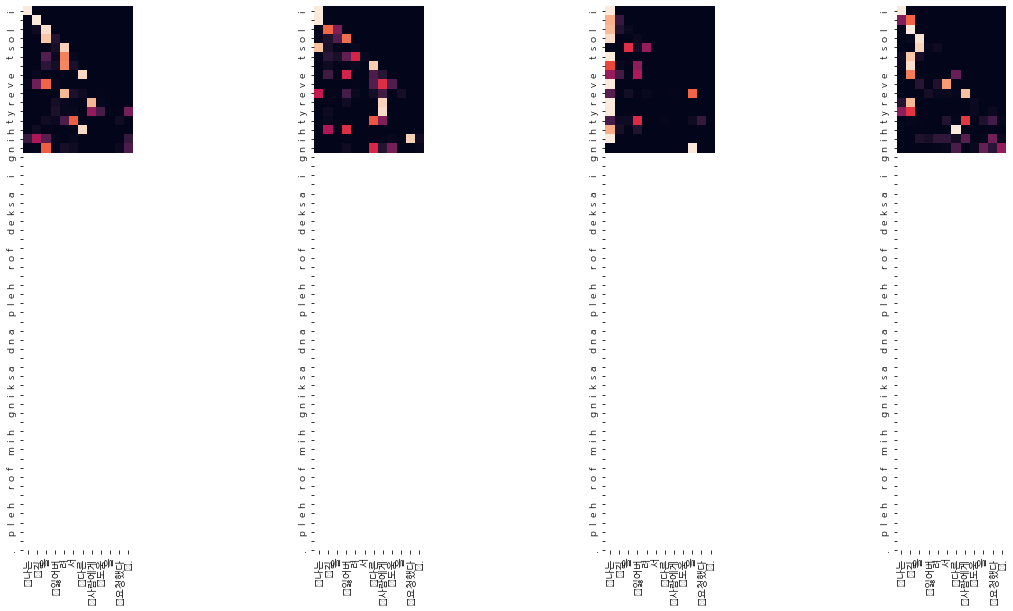

In [113]:

visualize_attention(pieces,result, enc_attns, dec_attns, dec_enc_attns)
